In [25]:
#########################File reading libraries#############################################
import os
import csv
from sklearn.cross_validation import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
################################Common Functions#############################################
def trans_image(image,steer,trans_range = 100,width=200,height=66):
    '''
    Function primarily used for image augmentation. This function does image translation using
    cv2 geometric transformation functions. image translated based on random x value and steering
    angle also adjusted with random value.
    '''
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    tr_y = 0
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(width,height))
    return image_tr,steer_ang   

def draw_histogram(hist, bins):
    '''
    Function used for drawing histogram.
    '''

    width = 0.8 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    #plt.plot((np.min(steer), np.max(steer)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
    plt.show()
    

def remove_steering(image,steer):
    '''
    Function used for removed steering angle bias. Most of the time during training car drive with ZERO steering angle(straight)
    driving, therefore, it causes bias in data. This method does UNDERSAMPLING by ramdomly removing images & steering angles valued
    ZERO.
    
    Steering angles angle around ZERO are removed using Histogram and data frequency values in bin. 25 bins are assigned and histogram
    is generated using np.histogram. This function returns bins and frequency in bins. If any particular bin is having data points above
    average number of data points in all bins, then, data will be propotionally removed from that bin to bring near to average number of
    data points.
    '''
    #Assign number of bins for histogram
    num_bins = 25
    avg_bin_sample_count = len(steer)/num_bins
    hist, bins = np.histogram(steer, num_bins)
    
    ###################histogram before
    draw_histogram(hist, bins)
    ###################removing steering values.
    
    steer_bins = []
    sample_indices = []
    
    bin_sample_limit = ceil(np.float(avg_bin_sample_count) * 0.7) #70% of average count.
    
    #print(avg_bin_sample_count)
    #print(bin_sample_limit)
    
    for i in range(len(steer)):
        for j in range(num_bins):
            if steer[i] >= bins[j] and steer[i] < bins[j+1]:
                steer_bins.append(bins[j])
                
    for i in range(num_bins):
        hist_indices = [j for j, x in enumerate(steer_bins) if x == bins[i]]
        if hist[i] >  bin_sample_limit:
            relative_sample_per_bin = int(((bin_sample_limit/hist[i]))*hist[i])
            random_indices = np.random.choice(hist_indices, relative_sample_per_bin  , replace=False) 
        else:
            random_indices = hist_indices 
        
        sample_indices.extend(random_indices)
     
    steer_bins_index = np.array(range(len(steer_bins)))
    
    mask = np.ones(steer_bins_index.shape,dtype=bool)
    mask[sample_indices] = False
    remove_indices = steer_bins_index[mask].tolist()
    
    #print(len(remove_indices))
    #remove_indices = np.array(np.arange(len(steer_bins)))[~sample_indices]# - np.array(sample_indices)).tolist()
    
    #print("Index removed count {}".format(remove_indices))

    image = np.delete(image, remove_indices, axis=0)
    steer = np.delete(steer, remove_indices)
    
    ###################histogram after
    hist, bins = np.histogram(steer, num_bins)
    print("---------------Histogram after random removal of biased elements")
    draw_histogram(hist, bins)
  
    return image,steer

def preprocess(image):
    '''
    Image cropping to remove area that does not provide input to model
    smoothing the image using Gaussian kernal
    Resizing image as required by Nvidia Model
    Adjusting COLOR
    '''
    image = image[50:140,:,:] # Image cropping removing 50 pixels in top and 20 pixels at bottom
    image = cv2.GaussianBlur(image, (3,3), 0) #Smoothing the image.
    image = cv2.resize(image,(200, 66), interpolation = cv2.INTER_AREA) #reducing image to fit Nvidia architecture
    image  = cv2.cvtColor(image, cv2.COLOR_BGR2YUV) #Adjusting channels.
    return image

print('function complete.')

function complete.


number of images before steering removal: (49215,)


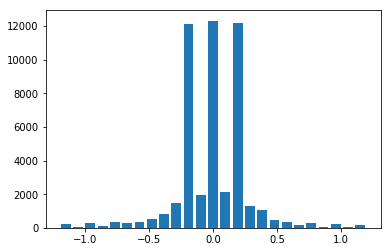

---------------Histogram after random removal of biased elements


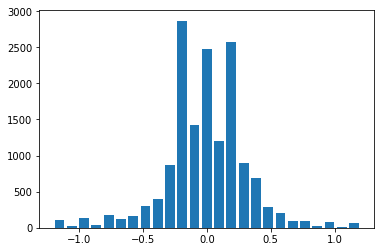

number of images after steering removal: (15340,)
Total samples: 15340
image lines read...split.
Training data size: 36816
Valid data size: 9204
./data/IMG/left_2016_12_01_13_37_51_798.jpg
0.3670138


In [26]:
import numpy as np
from sklearn.utils import shuffle
import cv2
import sklearn
import matplotlib.pyplot as plt
#########################Variable Initialize################################################
samples = []
lower_steering = []
images = []
steering = []
steering_correction = 0.2 


####Images picked up from the training directory. Images split into 6 different directories######

udacity_data = True
self_central,self_central_reverse,self_recovery,self_recoery_reverse,self_problem_areas = True,True,True,True,True
#Flag that will allow to pickup data
data_sources = [udacity_data,self_central,self_central_reverse,self_recovery,self_recoery_reverse,self_problem_areas]
#directory where driving_log.csv is present
data_paths = ['./data/','./train/central/','./train/central_reverse/','./train/recovery/','./train/recovery_reverse/','./train/problem_areas/']
#directory where images are present.
image_paths = ['./data/IMG/','./train/central/IMG/','./train/central_reverse/IMG/','./train/recovery/IMG/','./train/recovery_reverse/IMG/','./train/problem_areas/IMG/']
field_seperator = ['/','\\','\\','\\','\\','\\']

############################################Reading data#####################################

for i in range(len(data_paths)):
    if data_sources[i] == False:
        continue

    with open(data_paths[i]+'driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            images.append(image_paths[i]+line[0].split(field_seperator[i])[-1])
            steering.append(float(line[3]))
            images.append(image_paths[i]+line[1].split(field_seperator[i])[-1])
            steering.append(float(line[3])+steering_correction)
            images.append(image_paths[i]+line[2].split(field_seperator[i])[-1])
            steering.append(float(line[3])-steering_correction)
        
        


##########################################Remove steering bias ############################

images,steering = np.array(images),np.array(steering)
print("number of images before steering removal: {}".format(images.shape))
images, steering = remove_steering(images,steering)
print("number of images after steering removal: {}".format(images.shape))
samples = [[x,y] for x,y in zip(images.tolist(),steering.tolist())]
#print("Total samples: {}".format(len(samples)))
train_sample, valid_sample = train_test_split(samples,test_size=0.2, random_state=25)
#print('image lines read...split.')
        
###########################Generator related libraries#####################################


def generate(samples, batch_size=32):
        no_samples = len(samples)
        shuffle(samples)
        batch_size = int(batch_size/3)
        while True:
            for idx in range(0,no_samples,batch_size):
                batch_samples = samples[idx:idx+batch_size] 
                images = []
                angles = []
                for i in range(0,len(batch_samples)):
                    name = batch_samples[i][0]
                    angle = batch_samples[i][1]
                    image = cv2.imread(name)
                    image = preprocess(image)
                    images.append(image)
                    angles.append(angle)

                    flip_img = np.fliplr(image)
                    flip_angle = -angle
                    images.append(flip_img)
                    angles.append(flip_angle)

                        
                    ##Random adjust image & steering
                    rand_img, rand_steer = trans_image(image,angle,100,200,66)
                    images.append(rand_img)
                    angles.append(rand_steer)
                        
            # trim image to only see section with road
                X_train = np.array(images)
                y_train = np.array(angles)
               # print(X_train.shape, y_train.shape)
                yield shuffle(X_train, y_train)
        
train_generate = generate(train_sample, batch_size=270)
valid_generate = generate(valid_sample, batch_size=270)


print("Training data size: {}".format(len(train_sample)*3))
print("Valid data size: {}".format(len(valid_sample)*3))
#print(train_sample[0][0])
#print(train_sample[0][1])

In [27]:
#################################Model libraries###################################################
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Activation,Lambda,Cropping2D,Flatten,Convolution2D,MaxPooling2D,Reshape,Dropout
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, Callback

##########################################Nvidia model###########################################################
model_n = Sequential()
model_n.add(Lambda(lambda x: x/127.5 - 1.0, input_shape=(66,200,3)))
model_n.add(Convolution2D(24,5,5,subsample=(2,2),activation="elu"))
model_n.add(Convolution2D(36,5,5,subsample=(2,2),activation="elu"))
model_n.add(Convolution2D(48,5,5,subsample=(2,2),activation="elu"))
model_n.add(Convolution2D(64,3,3,activation="elu"))
model_n.add(Convolution2D(64,3,3,activation="elu"))
model_n.add(Flatten())
model_n.add(Dense(1164))
model_n.add(Dropout(0.5))
model_n.add(Dense(100))
model_n.add(Dropout(0.4))
model_n.add(Dense(50))
model_n.add(Dropout(0.3))
model_n.add(Dense(10))
#model_n.add(Dropout(0.2))
model_n.add(Dense(1))
adam_n = Adam(lr=0.001)
model_n.compile(optimizer=adam_n,loss='mse')
###############################Train the model & Validation######################################################

checkpoint = ModelCheckpoint('model_{epoch:02d}.h5')

#history_object = model_n.fit_generator(train_generate, samples_per_ epoch=len(train_sample)*2, \
#                                       validation_data=valid_generate, nb_val_samples=len(valid_sample)*2, \
#                                       nb_epoch=7, verbose = 1, callbacks = [checkpoint])


history_object = model_n.fit_generator(train_generate, samples_per_epoch=len(train_sample)*3, \
                                     validation_data=valid_generate,nb_val_samples=len(valid_sample)*3, \
                                     nb_epoch=7,verbose = 1,callbacks = [checkpoint])

print('Nvidia training & validation...')
print(model_n.summary())
    
model_n.save_weights('./model.h5')
#model_n.save('full_model.h5')
json_string = model_n.to_json()
with open('./model.json', 'w') as f:
    f.write(json_string)

#print(model_n.summary())
    


Epoch 1/7
36816/36816 [==============================] - 397s - loss: 0.1099 - val_loss: 0.0781

dict_keys(['val_loss', 'loss'])


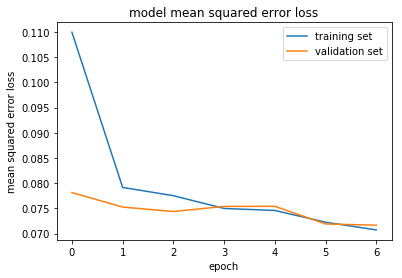

In [28]:
##############################  Visualize training/Validation output#############################################
import matplotlib.pyplot as plt

print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
